In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
from Environment import Environment
from Agent import Agent
import numpy as np
from plot import plot
from Display import disp
from termcolor import colored

In [26]:
def run():
    sigma = 1e-2
    env = Environment(num_of_antennas=5, num_of_irs1=5, num_of_irs2=5,
                        path_loss_exponent=2, irs1_to_antenna=20,
                        irs2_to_antenna=30, irs1_to_irs2=40, transmitted_power=1)

    U1 = env.CreateUser(distance_to_antenna=50, distance_to_irs1=50, distance_to_irs2=30,
                        noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                        los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)

    U2 = env.CreateUser(distance_to_antenna=60, distance_to_irs1=40, distance_to_irs2=20,
                        noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                        los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)
    

    num_of_actions = env.M1 + env.M2 + len(env.Users) * env.N + env.num_of_users - 1

    agent = Agent(num_states=env.num_of_users, bound=1, batch_size=128, max_size=100000,
                    env=env, n_actions=num_of_actions,
                    noise=0.02, alpha=0.0002, beta=0.0004, fc1=512, fc2=256)


    num_of_episodes = 50
    num_of_iterations = 80

    score_history = np.zeros((num_of_episodes,))
    rewards = np.zeros((num_of_episodes, num_of_iterations))
    sumrate = np.zeros((num_of_episodes, num_of_iterations))
    U1_SINR = np.zeros((num_of_episodes, num_of_iterations))
    U2_SINR = np.zeros((num_of_episodes, num_of_iterations))

    Old_Avg = 0
    obs = env.State()

    for ep in range(num_of_episodes):
        score = 0
        # obs = env.State()

        if ep < num_of_episodes / 5:
            agent.noise = 0.5
        elif ep < num_of_episodes * 2 / 5:
            agent.noise = 0.3
        elif ep < num_of_episodes * 3 / 5:
            agent.noise = 0.2
        elif ep < num_of_episodes * 4 / 5:
            agent.noise = 0.1
        elif ep < num_of_episodes - 6 :
            agent.noise = 0.05
        else:
            agent.noise = 0

        for iter in range(num_of_iterations):
            action = agent.choose_action(obs)

            new_state, reward, sumrate[ep][iter], SINRs = env.Step(action)
            # if reward != 0 : 
            agent.remember(obs, action, reward, new_state)
                
            agent.learn()
            obs = new_state
            score += reward
            rewards[ep][iter] = reward

            U1_SINR[ep][iter] = SINRs[0]
            U2_SINR[ep][iter] = SINRs[1]

        # agent.learn()
        score = score / num_of_iterations
        score_history[ep] = score
        New_Avg = score_history[:ep + 1].mean()

        disp(episod=ep, score=score, score_history=score_history,
                New_Avg=New_Avg, Old_Avg=Old_Avg, SINRs=SINRs, sumrate=sumrate[ep][iter])
        
        ac = np.array(action)
        power_noise = np.array(agent.power_noise)
        print("Power split factor = "+ colored(f"{ac[-1 : ][0]: <5.2}", "blue") +
            "| Power noise = " + colored(f"{power_noise[-1]: <5.2}", "blue") )
        
        # print(agent.memory.buffer_counter)

        obs = env.Reset()
        Old_Avg = New_Avg

    plot(score_history=score_history, sumrate=sumrate,
            u1_sinr=U1_SINR, u2_sinr=U2_SINR, mean=False,
            title=f"N = {env.N}, M1 = {env.M1}, M2 = {env.M2}")
    
    return U1, U2
    

Episode 1   Score ->  1.15      Avg-Score ->  1.15      + Max 😀 U1-SINR ->  0.58    U2-SINR ->  0.06    Sumrate ->  0.74   
Power split factor = 0.85 | Power noise = 0.37 
Episode 2   Score ->  0.88      Avg-Score ->  1.02      -        U1-SINR ->  0.00    U2-SINR ->  2.26    Sumrate ->  1.70   
Power split factor = 0.0  | Power noise = -0.7 
Episode 3   Score ->  1.45      Avg-Score ->  1.16      + Max 😀 U1-SINR ->  1.05    U2-SINR ->  0.29    Sumrate ->  1.40   
Power split factor = 0.64 | Power noise = 0.13 
Episode 4   Score ->  2.63      Avg-Score ->  1.53      + Max 😀 U1-SINR ->  1.85    U2-SINR ->  4.96    Sumrate ->  4.09   
Power split factor = 0.34 | Power noise = -0.082
Episode 5   Score ->  2.71      Avg-Score ->  1.77      + Max 😀 U1-SINR ->  2.08    U2-SINR ->  0.21    Sumrate ->  1.89   
Power split factor = 0.76 | Power noise = 0.26 
Episode 6   Score ->  3.14      Avg-Score ->  2.00      + Max 😀 U1-SINR ->  0.00    U2-SINR ->  4.85    Sumrate ->  2.55   
Power split fa

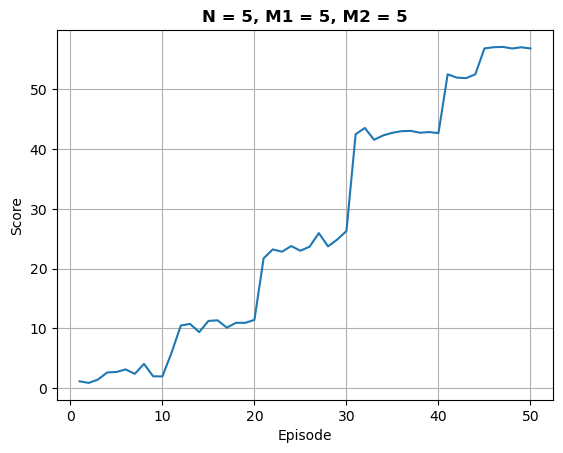

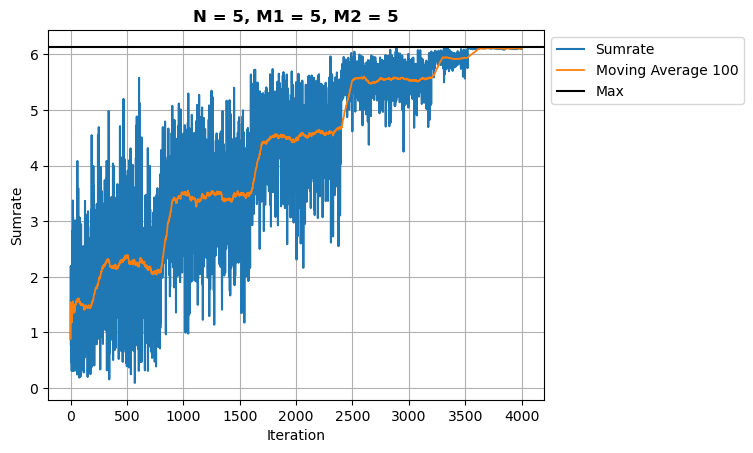

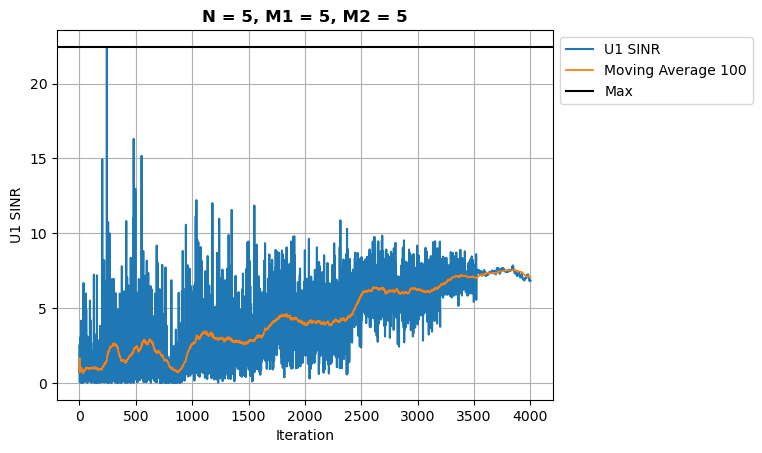

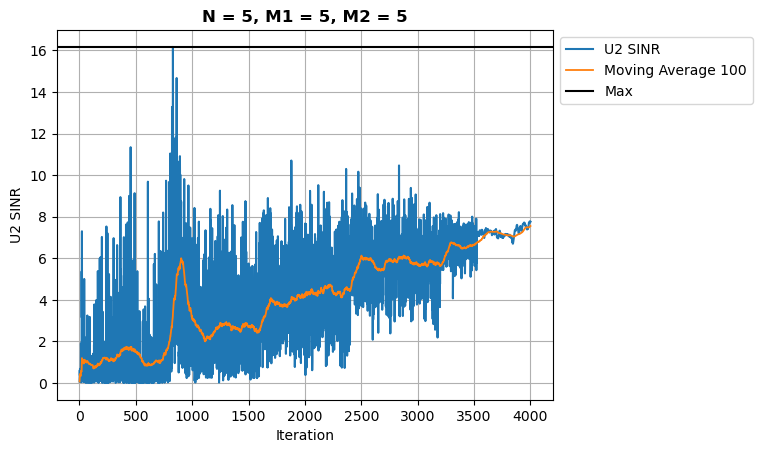

In [27]:
U1, U2 = run()

In [52]:
print(np.diag(np.angle(env.Psi1, deg=True)))
print("************************************************************************************")
print(np.diag(np.angle(env.Psi2, deg=True)))
print("************************************************************************************")
print(max(sumrate.reshape(num_of_episodes*num_of_iterations,)))

[  5.80351911 102.90995479 123.30667377  60.71778774  78.84238601]
************************************************************************************
[1.80000000e+02 1.80000000e+02 1.79999979e+02 1.78838679e+02
 6.44566103e-04]
************************************************************************************
6.4951752893006685


In [24]:
print(np.linalg.norm(U1.w)**2 + np.linalg.norm(U2.w)**2)
print(U1.allocated_power + U2.allocated_power)

1.0
1.0
